<a href="https://colab.research.google.com/github/yogin16/notebooks/blob/master/deep-reinforcement-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning
Reinforcement Learning is a type of machine learning that allows you to create AI agents that learn from the environment by interacting with it. Just like how we learn to ride a bicycle, this kind of AI learns by trial and error. As seen in the picture, the brain represents the AI agent, which acts on the environment. After each action, the agent receives the feedback. The feedback consists of the reward and next state of the environment. The reward is usually defined by a human. If we use the analogy of the bicycle, we can define reward as the distance from the original starting point.

![reinforcement learning](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)


# Deep Reinforcement Learning

In Q-Learning Algorithm, there is a function called Q Function, which is used to approximate the reward based on a state. We call it Q(s,a), where Q is a function which calculates the expected future value from state s and action a. Similarly in Deep Q Network algorithm, we use a neural network to approximate the reward based on the state. We will discuss how this works in detail.

So the "Agent" is a deep learning neural network.

## install dependancies, takes around 45 seconds

In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [0]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install pyglet==1.3.2

     |████████████████████████████████| 583kB 2.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 41.4.0
    Uninstalling setuptools-41.4.0:
      Successfully uninstalled setuptools-41.4.0


## imports and helper functions

In [0]:
import gym
import os
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
# supressing extra logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = sorted(glob.glob('video/*.mp4'), key=os.path.getmtime)
  print(mp4list)
  if len(mp4list) > 0:
    for mp4 in mp4list:
      # mp4 = mp4list[-1]
      print(mp4)
      video = io.open(mp4, 'r+b').read()
      encoded = base64.b64encode(video)
      ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  # use this if you want to record every thing
  # env = Monitor(env, './video', force=True, video_callable=lambda episode_id: True)
  # record every 10th episode
  env = Monitor(env, './video', force=True, video_callable=lambda episode_id: episode_id%10==0)
  return env

# CartPole
![cartpole](https://keon.io/images/deep-q-learning/animation.gif)

CartPole is one of the simplest environments in OpenAI gym (a game simulator). As you can see in the animation from the top, the goal of CartPole is to balance a pole connected with one joint on top of a moving cart. Instead of pixel information, there are 4 kinds of information given by the state, such as angle of the pole and position of the cart. An agent can move the cart by performing a series of actions of 0 or 1 to the cart, pushing it left or right.

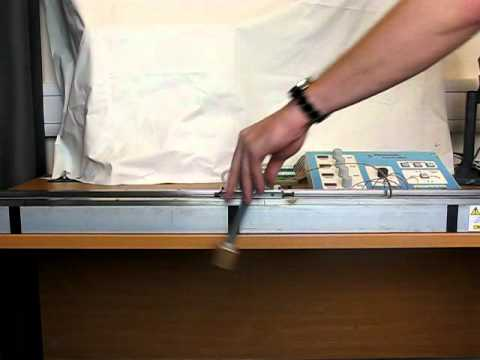

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('XiigTGKZfks')

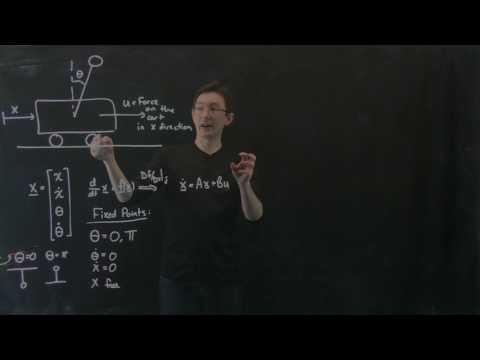

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('qjhAAQexzLg')

In [0]:
EPISODES = 71 #1000

# Agent

Our agent is applying Q-Learning technique. Specifically, "Deep Q-Learning" because it is using nueral network to replay the rewards.

In [0]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon: # Explore with epsilon probability
        # This makes the whole system stochastic. So running it again would yield similar but different results
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# Enviroment

In any reinforcement learning setup, environment is a given.

Here, we are using `gym` library to simulate the 'CartPole' problem environment.

In [0]:
env = wrap_env(gym.make("CartPole-v1"))
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
# agent.load("./save/cartpole-dqn.h5")
done = False
batch_size = 32

In [0]:
score = []
for e in range(EPISODES):
  state = env.reset()
  state = np.reshape(state, [1, state_size])
  for time in range(500):
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    reward = reward if not done else -10
    next_state = np.reshape(next_state, [1, state_size])
    agent.remember(state, action, reward, next_state, done)
    state = next_state
    if done:
      score.append(time)
      print("episode: {}/{}, score: {}, epsilon: {:.2}".format(e, EPISODES, time, agent.epsilon))
      break
    if len(agent.memory) > batch_size:
      agent.replay(batch_size)
  # if e % 10 == 0:
  #     agent.save("./save/cartpole-dqn.h5")
env.render()
env.close()
print('after {} episodes of training'.format(EPISODES))
show_videos()

episode: 0/71, score: 12, epsilon: 1.0
episode: 1/71, score: 47, epsilon: 0.87
episode: 2/71, score: 20, epsilon: 0.79
episode: 3/71, score: 36, epsilon: 0.66
episode: 4/71, score: 14, epsilon: 0.61
episode: 5/71, score: 20, epsilon: 0.55
episode: 6/71, score: 13, epsilon: 0.52
episode: 7/71, score: 10, epsilon: 0.49
episode: 8/71, score: 13, epsilon: 0.46
episode: 9/71, score: 9, epsilon: 0.44
episode: 10/71, score: 11, epsilon: 0.42
episode: 11/71, score: 13, epsilon: 0.39
episode: 12/71, score: 12, epsilon: 0.37
episode: 13/71, score: 14, epsilon: 0.34
episode: 14/71, score: 12, epsilon: 0.32
episode: 15/71, score: 10, epsilon: 0.31
episode: 16/71, score: 10, epsilon: 0.29
episode: 17/71, score: 10, epsilon: 0.28
episode: 18/71, score: 15, epsilon: 0.26
episode: 19/71, score: 15, epsilon: 0.24
episode: 20/71, score: 8, epsilon: 0.23
episode: 21/71, score: 9, epsilon: 0.22
episode: 22/71, score: 12, epsilon: 0.21
episode: 23/71, score: 9, epsilon: 0.2
episode: 24/71, score: 28, epsil

video/openaigym.video.0.126.video000010.mp4


video/openaigym.video.0.126.video000020.mp4


video/openaigym.video.0.126.video000030.mp4


video/openaigym.video.0.126.video000040.mp4


video/openaigym.video.0.126.video000050.mp4


video/openaigym.video.0.126.video000060.mp4


video/openaigym.video.0.126.video000070.mp4


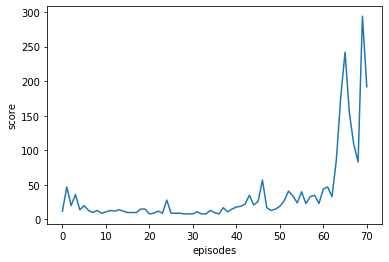

In [0]:
plt.plot(score)
plt.xlabel("episodes")
plt.ylabel("score")
plt.show()